### https://www.tensorflow.org/tutorials/video/video_classification

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.11.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\public\new\envs\tensorflowraul\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [2]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

from pathlib import Path

In [3]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [4]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 60):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [5]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [6]:
n_frames = 10
batch_size = 1

# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips/train'), n_frames, training=True),
                                          output_signature = output_signature)

In [7]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips/val'), n_frames),
                                        output_signature = output_signature)

In [8]:
# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips/test'), n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

In [9]:
#####
#####
#####

In [10]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [11]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [12]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [13]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [14]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [15]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [16]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [17]:
#next(iter(train_ds))

In [18]:
frames, label = next(iter(train_ds))
model.build(frames)

In [19]:
#label

In [20]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [22]:
history = model.fit(x = train_ds, epochs = 50, validation_data = val_ds)

Epoch 1/50
117/117 [==============================] - 255s 2s/step - loss: 1.8078 - accuracy: 0.4274 - val_loss: 1.7085 - val_accuracy: 0.3409
Epoch 2/50
117/117 [==============================] - 254s 2s/step - loss: 1.4580 - accuracy: 0.4530 - val_loss: 1.7780 - val_accuracy: 0.3409
Epoch 3/50
117/117 [==============================] - 246s 2s/step - loss: 1.4099 - accuracy: 0.3846 - val_loss: 2.1662 - val_accuracy: 0.3409
Epoch 4/50
117/117 [==============================] - 239s 2s/step - loss: 1.3623 - accuracy: 0.3846 - val_loss: 1.6817 - val_accuracy: 0.3409
Epoch 5/50
117/117 [==============================] - 256s 2s/step - loss: 1.3755 - accuracy: 0.3675 - val_loss: 1.8583 - val_accuracy: 0.3409
Epoch 6/50
117/117 [==============================] - 237s 2s/step - loss: 1.3641 - accuracy: 0.3675 - val_loss: 1.8972 - val_accuracy: 0.3409
Epoch 7/50
117/117 [==============================] - 235s 2s/step - loss: 1.2935 - accuracy: 0.4444 - val_loss: 1.8224 - val_accuracy: 0.3409

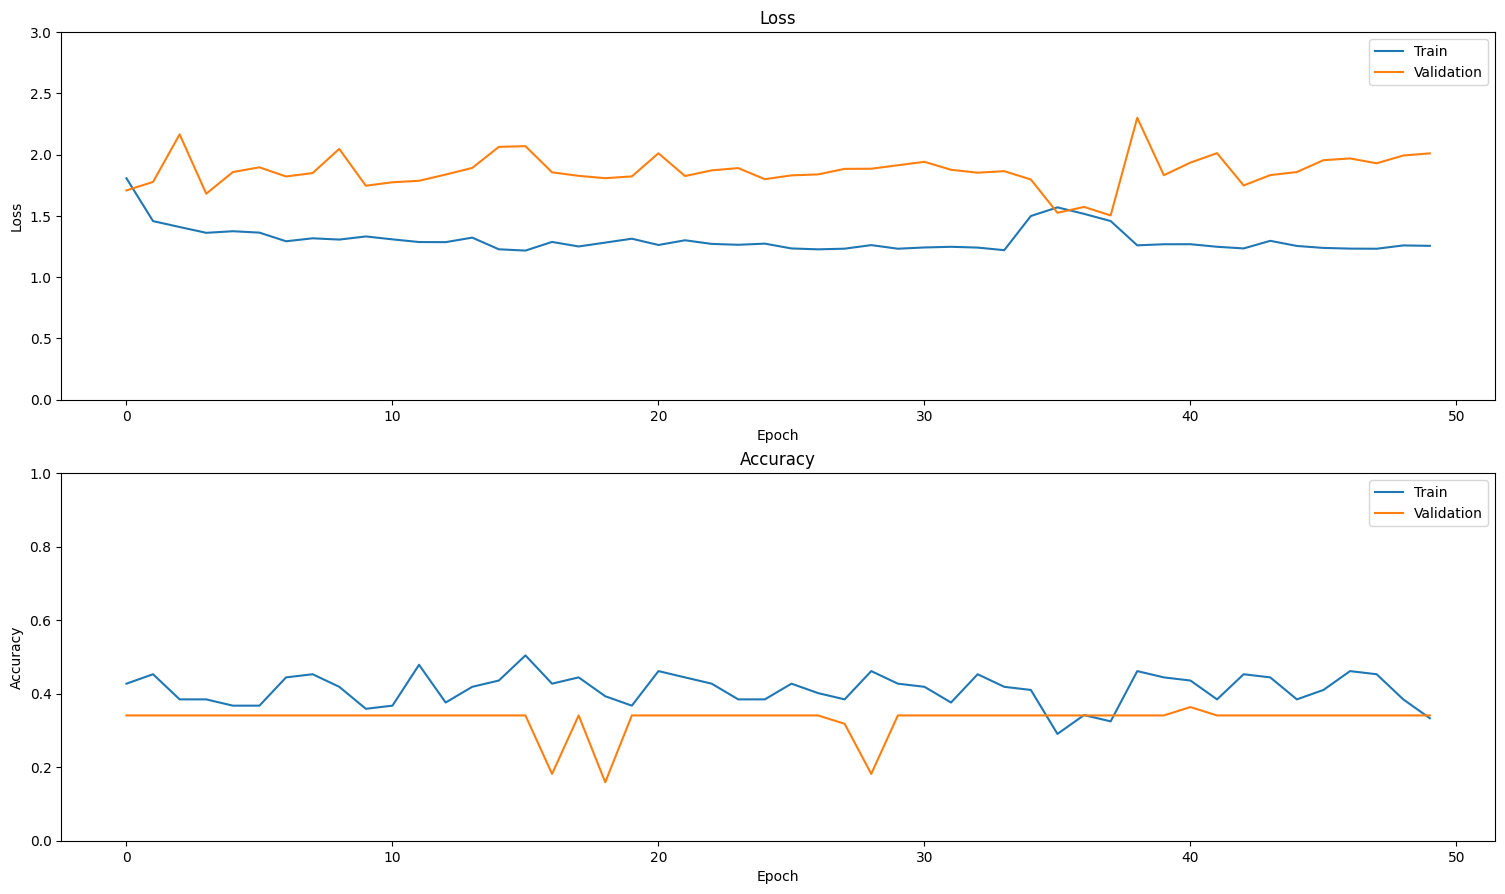

In [23]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [24]:
model.evaluate(test_ds, return_dict=True)

38/38 [==============================] - 35s 916ms/step - loss: 2.7614 - accuracy: 0.0000e+00


{'loss': 2.7613940238952637, 'accuracy': 0.0}

In [25]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [26]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [28]:
fg = FrameGenerator(Path('Summarys_labels/Sep_Clips/train'), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

117/117 [==============================] - 125s 1s/step


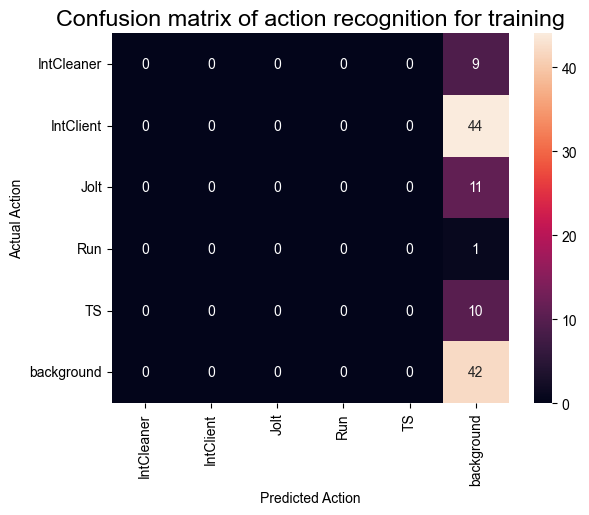

In [29]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

38/38 [==============================] - 35s 909ms/step


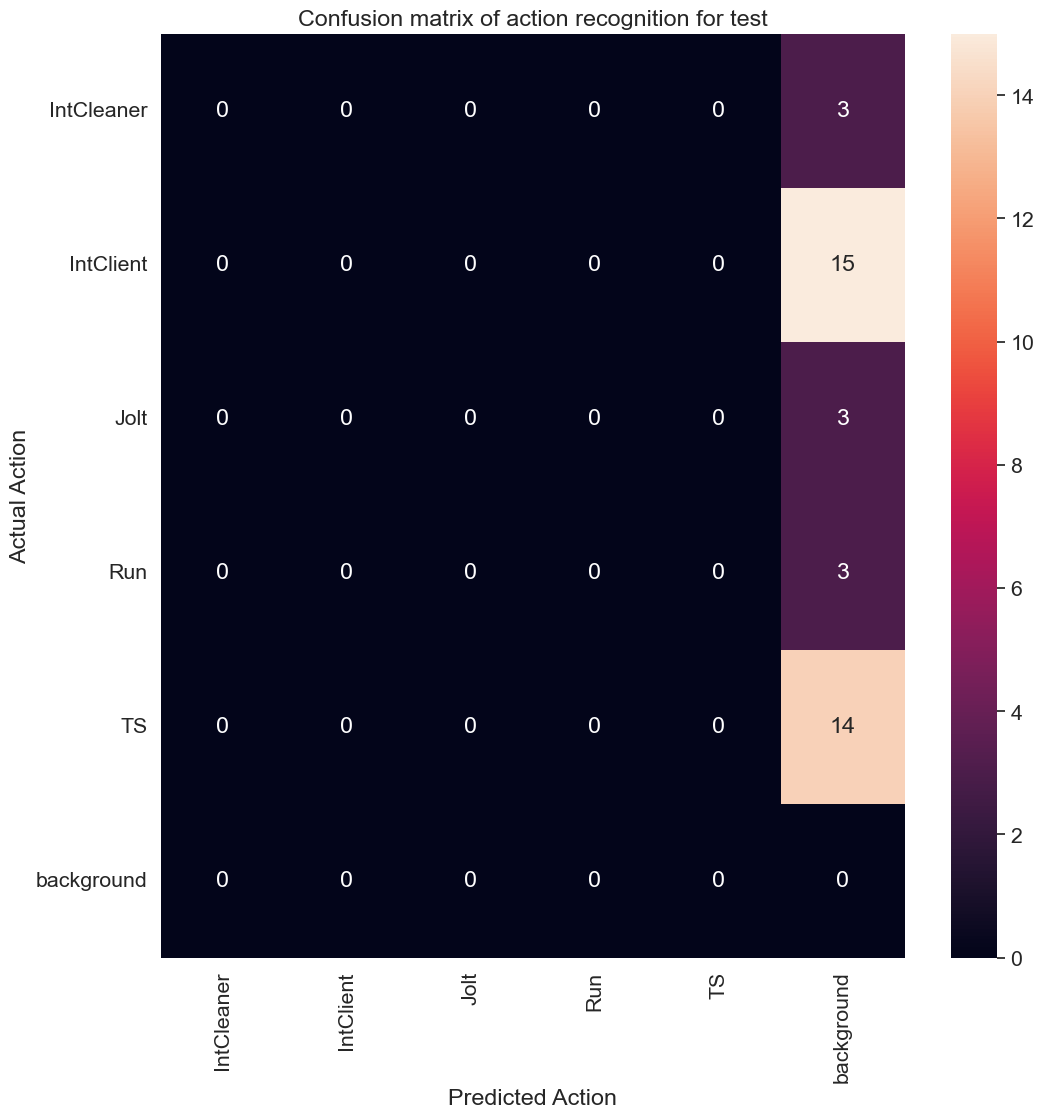

In [30]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [31]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [32]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

C:\Users\BEE Team\AppData\Local\Temp\ipykernel_17072\3092751621.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision
C:\Users\BEE Team\AppData\Local\Temp\ipykernel_17072\3092751621.py:27: RuntimeWarning: invalid value encountered in long_scalars
  recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall


In [33]:
precision

{'IntCleaner': nan,
 'IntClient': nan,
 'Jolt': nan,
 'Run': nan,
 'TS': nan,
 'background': 0.0}

In [34]:
recall

{'IntCleaner': 0.0,
 'IntClient': 0.0,
 'Jolt': 0.0,
 'Run': 0.0,
 'TS': 0.0,
 'background': nan}

In [51]:
import cv2
import os

# Path to the main folder containing subdirectories with videos
main_folder_path = r"C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\test"

# Loop through all subdirectories inside the main folder
for root, dirs, files in os.walk(main_folder_path):
    for dir in dirs:
        sub_folder_path = os.path.join(root, dir)

        # Loop through all video files inside the subdirectory
        for filename in os.listdir(sub_folder_path):
            if filename.endswith(".mp4") or filename.endswith(".avi"):
                # Open the video file
                video = cv2.VideoCapture(os.path.join(sub_folder_path, filename))

                # Get the total number of frames
                total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

                print(f"Number of frames in {os.path.join(sub_folder_path, filename)}: {total_frames}")

                # Release the video object
                video.release()


Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\test\background\background_13.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\test\background\background_31.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\test\background\background_33.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\test\background\background_34.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\test\background\background_49.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\test\background\background_52.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\test\background\background_54.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\test\background\background_60.mp4: 120
Number of frames in C:\Users\BEE

In [53]:
# Path to the main folder containing subdirectories with videos
main_folder_path = r"C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train"

# Loop through all subdirectories inside the main folder
for root, dirs, files in os.walk(main_folder_path):
    for dir in dirs:
        sub_folder_path = os.path.join(root, dir)

        # Loop through all video files inside the subdirectory
        for filename in os.listdir(sub_folder_path):
            if filename.endswith(".mp4"):
                # Open the video file
                video = cv2.VideoCapture(os.path.join(sub_folder_path, filename))

                # Get the total number of frames
                total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

                print(f"Number of frames in {os.path.join(sub_folder_path, filename)}: {total_frames}")

                # Release the video object
                video.release()

Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\background\background_0.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\background\background_1.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\background\background_10.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\background\background_11.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\background\background_12.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\background\background_17.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\background\background_18.mp4: 120
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\background\background_19.mp4: 120
Number of frames in C:\Use

Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\IntCleaner\IntClient_33.mp4: 64
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\IntCleaner\IntClient_34.mp4: 98
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\IntCleaner\IntClient_35.mp4: 45
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\IntCleaner\IntClient_36.mp4: 24
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\IntCleaner\IntClient_37.mp4: 80
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\IntCleaner\IntClient_38.mp4: 14
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\IntCleaner\IntClient_39.mp4: 23
Number of frames in C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips_Test\train\IntCleaner\IntClient_4.mp4: 31
Number of frames in C:\Users\BEE Team\Des

In [49]:
import os
p=r"C:\Users\BEE Team\Desktop\code\Summarys_labels\Sep_Clips\train\IntCleaner"
# Loop through all video files inside the subdirectory
for filename in os.listdir(p):
    if filename.endswith(".mp4") or filename.endswith(".avi"):
        # Open the video file
        video = cv2.VideoCapture(os.path.join(filename))

        # Get the total number of frames
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Number of frames in {os.path.join(filename)}: {total_frames}")

        # Release the video object
        video.release()

Number of frames in IntCleaner_0.mp4: 0
Number of frames in IntCleaner_1.mp4: 0
Number of frames in IntCleaner_11_0.mp4: 0
Number of frames in IntCleaner_11_1.mp4: 0
Number of frames in IntCleaner_2.mp4: 0
Number of frames in IntCleaner_3.mp4: 0
Number of frames in IntCleaner_5_0.mp4: 0
Number of frames in IntCleaner_5_1.mp4: 0
Number of frames in IntCleaner_7.mp4: 0


### ---
### Data joined interactions and jolt+run
### ---

In [45]:
n_frames = 10
batch_size = 1

# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds_new = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips_Test/train'), n_frames, training=True),
                                          output_signature = output_signature)

In [46]:
# Create the validation set
val_ds_new = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips_Test/val'), n_frames),
                                        output_signature = output_signature)

In [47]:
# Batch the data
train_ds_new = train_ds_new.batch(batch_size)

val_ds_new = val_ds_new.batch(batch_size)

test_ds_new = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips_test2/test'), n_frames),
                                         output_signature = output_signature)

test_ds_new = test_ds_new.batch(batch_size)

In [48]:
model_new = keras.Model(input, x)

In [49]:
frames, label = next(iter(train_ds_new))
model_new2.build(frames)

In [50]:
# Visualize the model
keras.utils.plot_model(model_new2, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [51]:
model_new.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [52]:
history_new = model_new2.fit(x = train_ds_new, epochs = 50, validation_data = val_ds_new)

Epoch 1/50
117/117 [==============================] - 242s 2s/step - loss: 1.6174 - accuracy: 0.4103 - val_loss: 1.3406 - val_accuracy: 0.5682
Epoch 2/50
117/117 [==============================] - 237s 2s/step - loss: 1.1613 - accuracy: 0.4530 - val_loss: 1.3885 - val_accuracy: 0.3409
Epoch 3/50
117/117 [==============================] - 236s 2s/step - loss: 1.0657 - accuracy: 0.4872 - val_loss: 1.5092 - val_accuracy: 0.3409
Epoch 4/50
117/117 [==============================] - 235s 2s/step - loss: 1.0051 - accuracy: 0.4872 - val_loss: 1.4514 - val_accuracy: 0.4091
Epoch 5/50
117/117 [==============================] - 236s 2s/step - loss: 1.0110 - accuracy: 0.4444 - val_loss: 1.4907 - val_accuracy: 0.4091
Epoch 6/50
117/117 [==============================] - 236s 2s/step - loss: 1.0139 - accuracy: 0.5299 - val_loss: 1.5020 - val_accuracy: 0.3409
Epoch 7/50
117/117 [==============================] - 235s 2s/step - loss: 1.0124 - accuracy: 0.3932 - val_loss: 1.5940 - val_accuracy: 0.3409

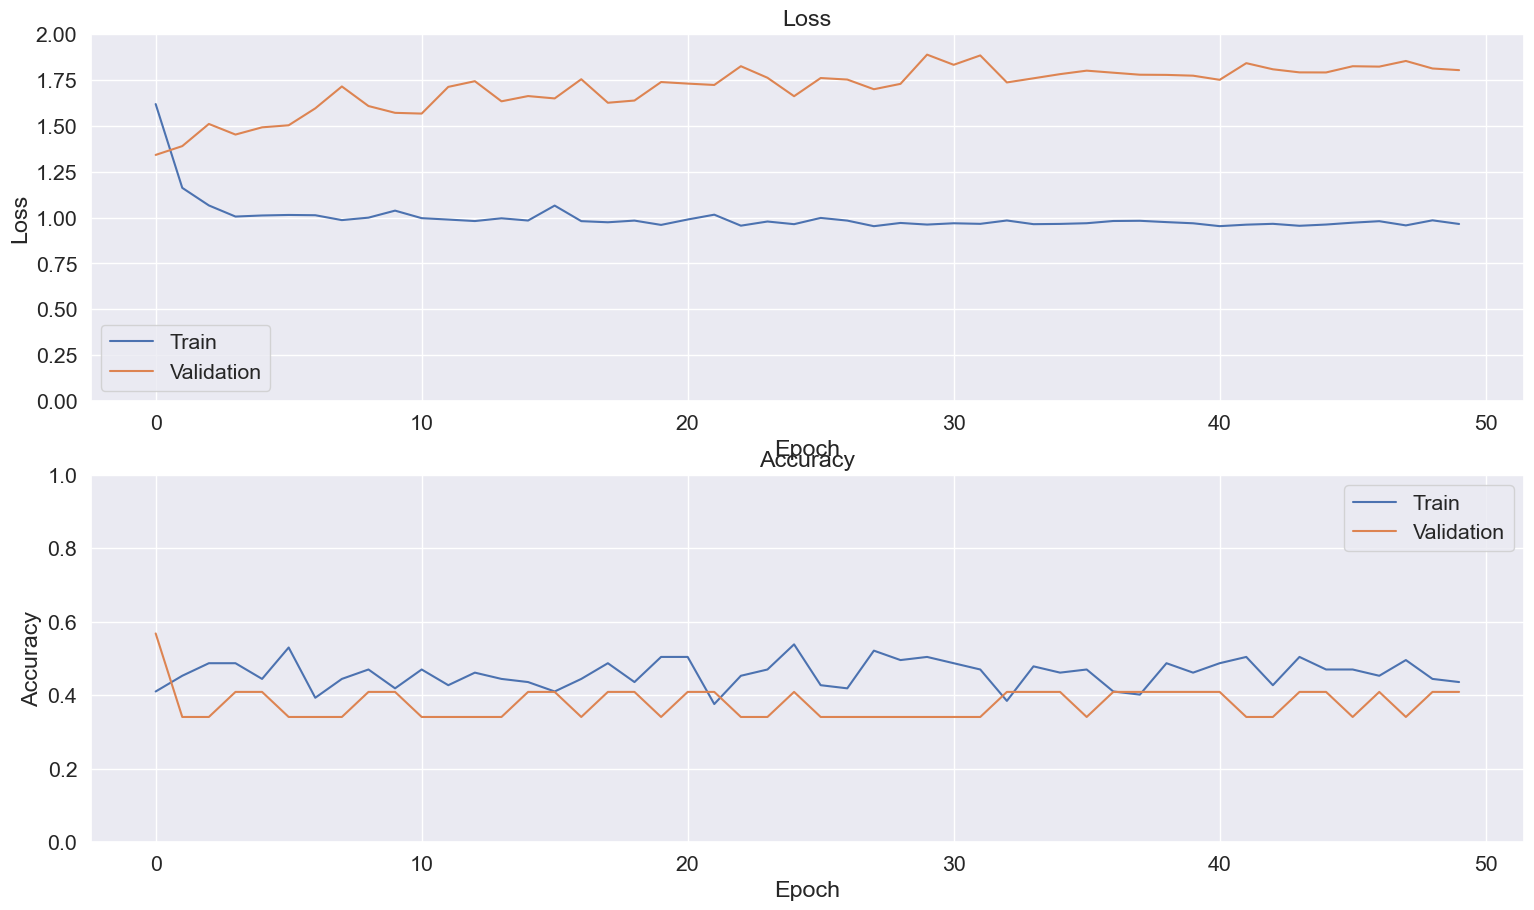

In [58]:
plot_history(history_new)

In [60]:
model.evaluate(test_ds_new, return_dict=True)

38/38 [==============================] - 36s 923ms/step - loss: 1.3985 - accuracy: 0.4737


{'loss': 1.398460030555725, 'accuracy': 0.4736842215061188}

In [63]:
fg = FrameGenerator(Path('Summarys_labels/Sep_Clips_Test/train'), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

117/117 [==============================] - 124s 1s/step


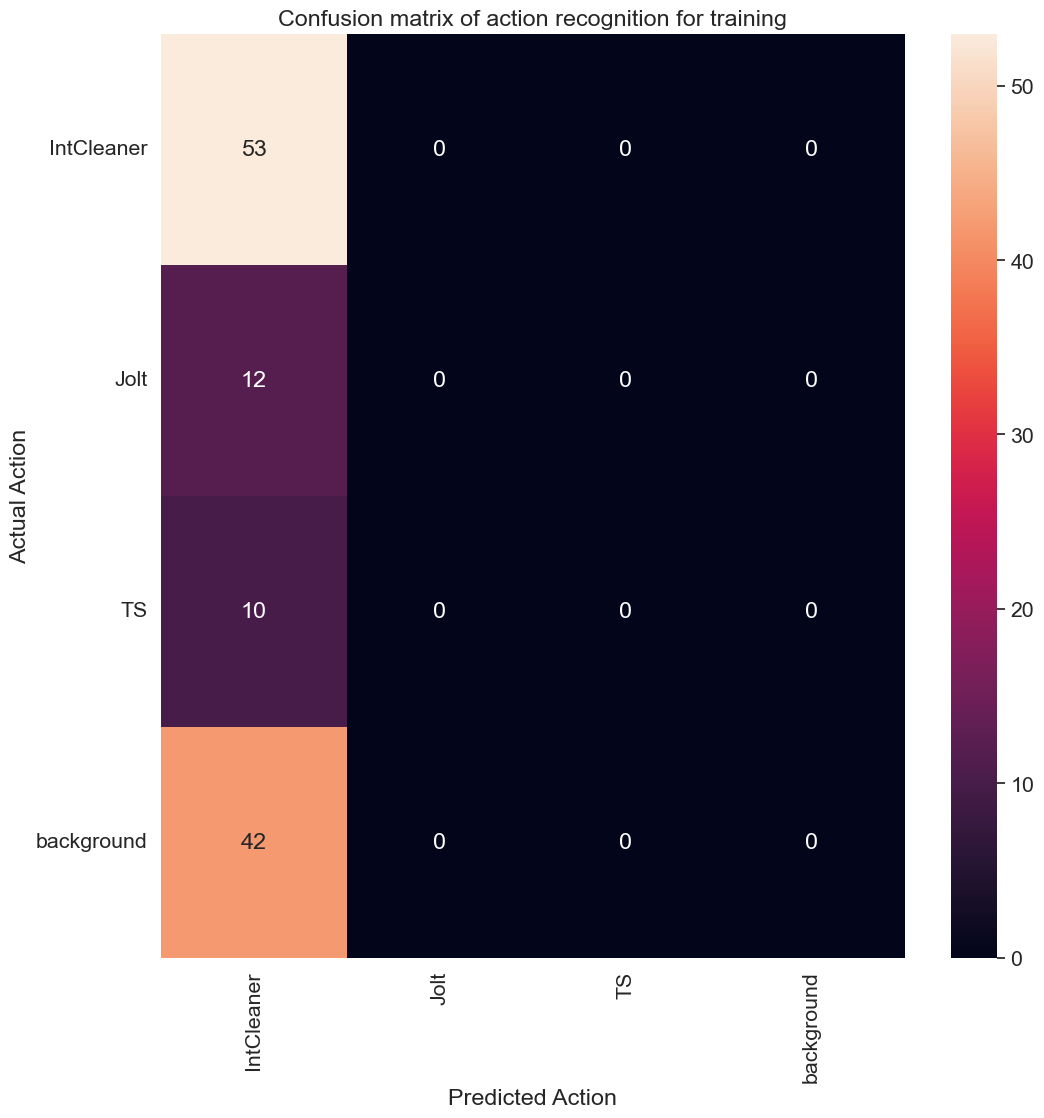

In [64]:
actual, predicted = get_actual_predicted_labels(train_ds_new)
plot_confusion_matrix(actual, predicted, labels, 'training')

38/38 [==============================] - 35s 909ms/step


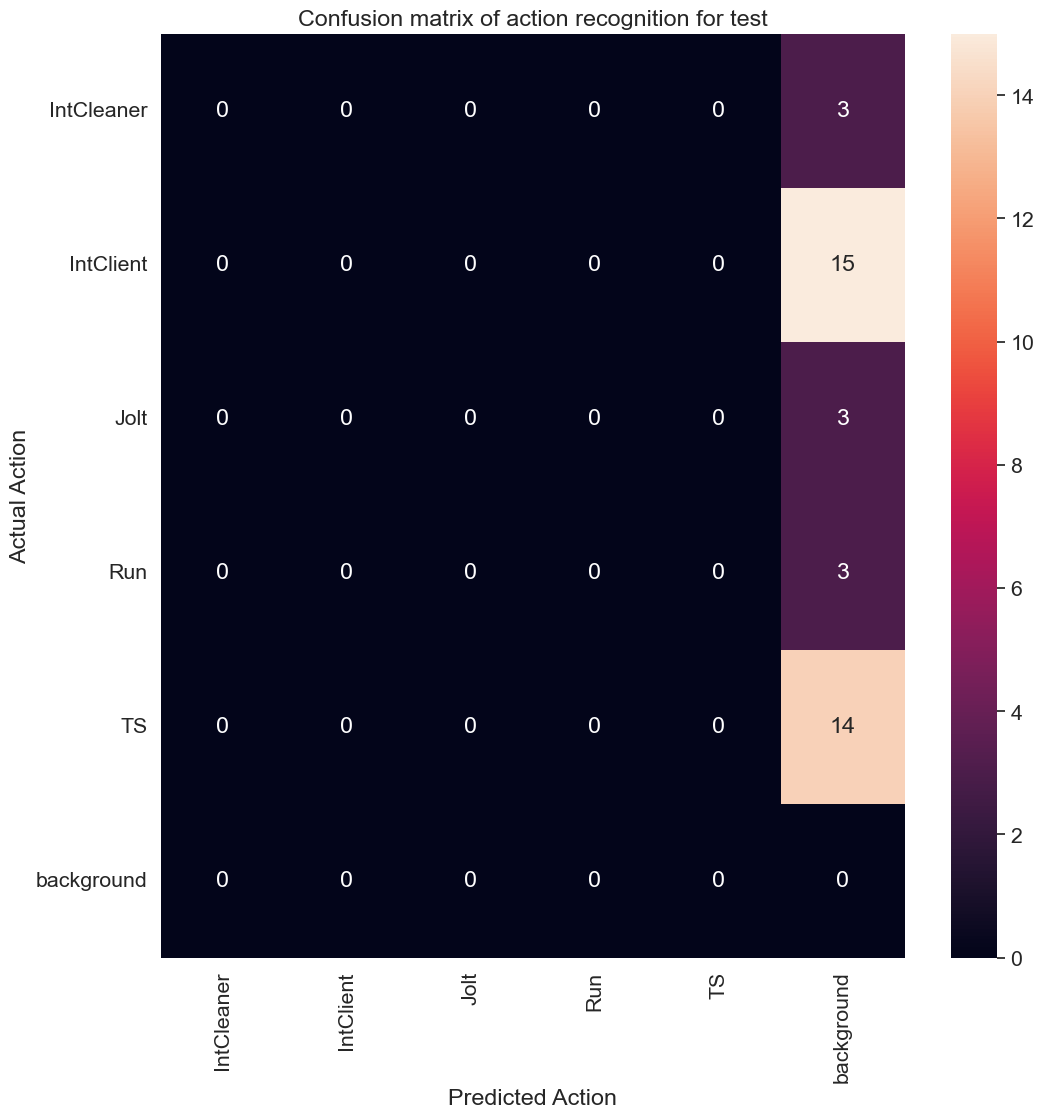

In [30]:
actual, predicted = get_actual_predicted_labels(test_ds_new)
plot_confusion_matrix(actual, predicted, labels, 'test')

### ---
### ---
### ---

### ---
### Data removed jolt+run+chase
### ---

In [45]:
n_frames = 10
batch_size = 1

# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds_new = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips_Test/train'), n_frames, training=True),
                                          output_signature = output_signature)

In [46]:
# Create the validation set
val_ds_new = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips_Test/val'), n_frames),
                                        output_signature = output_signature)

In [47]:
# Batch the data
train_ds_new = train_ds_new.batch(batch_size)

val_ds_new = val_ds_new.batch(batch_size)

test_ds_new = tf.data.Dataset.from_generator(FrameGenerator(Path('Summarys_labels/Sep_Clips_test/test'), n_frames),
                                         output_signature = output_signature)

test_ds_new = test_ds_new.batch(batch_size)

In [48]:
model_new = keras.Model(input, x)

In [49]:
frames, label = next(iter(train_ds_new))
model_new.build(frames)

In [50]:
# Visualize the model
keras.utils.plot_model(model_new, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [51]:
model_new.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [ ]:
history_new = model_new.fit(x = train_ds_new, epochs = 50, validation_data = val_ds_new)

Epoch 1/50
117/117 [==============================] - 242s 2s/step - loss: 1.6174 - accuracy: 0.4103 - val_loss: 1.3406 - val_accuracy: 0.5682
Epoch 2/50
117/117 [==============================] - 237s 2s/step - loss: 1.1613 - accuracy: 0.4530 - val_loss: 1.3885 - val_accuracy: 0.3409
Epoch 3/50
117/117 [==============================] - 236s 2s/step - loss: 1.0657 - accuracy: 0.4872 - val_loss: 1.5092 - val_accuracy: 0.3409
Epoch 4/50
117/117 [==============================] - 235s 2s/step - loss: 1.0051 - accuracy: 0.4872 - val_loss: 1.4514 - val_accuracy: 0.4091
Epoch 5/50
117/117 [==============================] - 236s 2s/step - loss: 1.0110 - accuracy: 0.4444 - val_loss: 1.4907 - val_accuracy: 0.4091
Epoch 6/50
117/117 [==============================] - 236s 2s/step - loss: 1.0139 - accuracy: 0.5299 - val_loss: 1.5020 - val_accuracy: 0.3409
Epoch 7/50
117/117 [==============================] - 235s 2s/step - loss: 1.0124 - accuracy: 0.3932 - val_loss: 1.5940 - val_accuracy: 0.3409

In [ ]:
plot_history(history_new)

In [ ]:
model.evaluate(test_ds_new, return_dict=True)

In [28]:
fg = FrameGenerator(Path('Summarys_labels/Sep_Clips_Test/train'), n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

117/117 [==============================] - 125s 1s/step


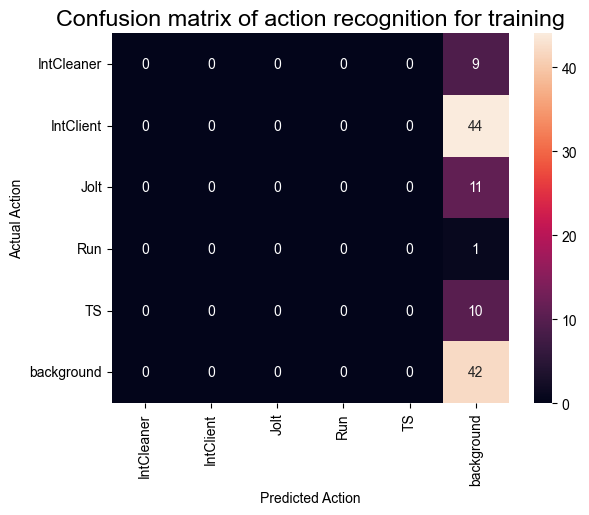

In [29]:
actual, predicted = get_actual_predicted_labels(train_ds_new)
plot_confusion_matrix(actual, predicted, labels, 'training')

38/38 [==============================] - 35s 909ms/step


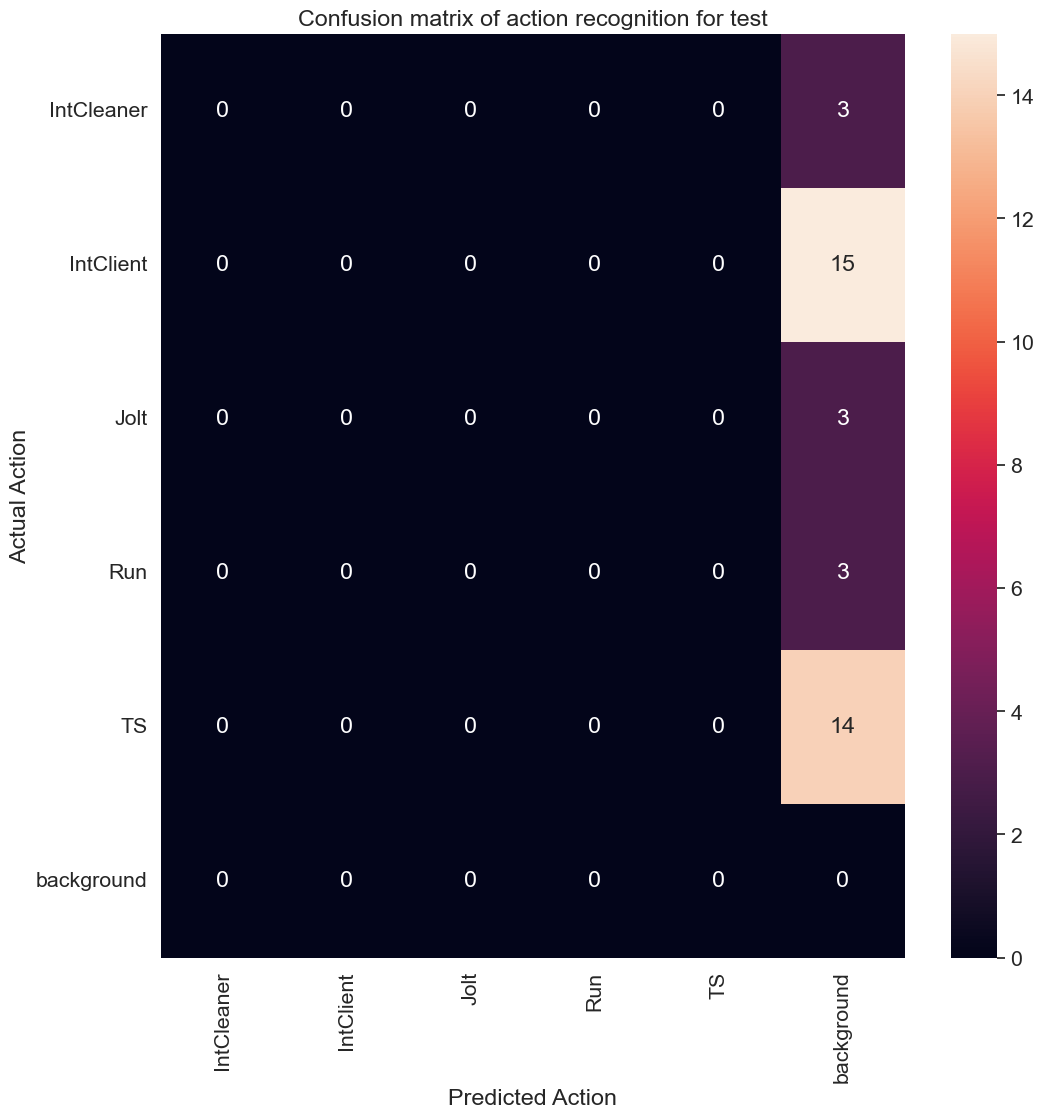

In [30]:
actual, predicted = get_actual_predicted_labels(test_ds_new)
plot_confusion_matrix(actual, predicted, labels, 'test')

### ---
### Data joined all interactions (Background || Interactions)
### ---